# Grid

A tutorial on grid classes, its properties and transformations.

### Content
* [Geometries](#Geometries)
    * [Orthogonal Grid](#Orthogonal-Grid)
    * [Corner-Point Grid](#Corner-Point-Grid)
* [Basic properties](#Basic-properties)
* [VTK grid](#VTK-grid)
* [Rescaling](#Rescaling)

## Geometries

Proceeding from the finite-difference simulation approach, spatial shape of the reservoir model is discretized into smaller parts called grid blocks (or cells).


### Orthogonal Grid

Grid describes the reservoir geometry (shape) and defines the blocks with which static and dynamic geological properties are associated.  If all cells are of the same parallelipiped shape and regular size we obtain the orthogonal grid. To specify such a grid one has to set a number of cells in each direction (nx, ny, nz) and cell sizes (dx, dy, dz).

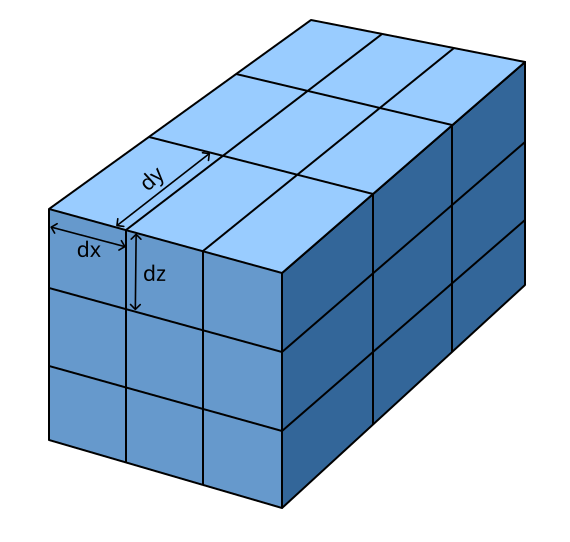



In `DeepField`, grids of this type are represented using the `OrthogonalGrid` class. In particular, Egg model has a orthogonal grid. Let's load the part of this model that only describes the grid (note that we specify the `config` parameter in the `load` method to load only the required keywords):

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

from deepfield import Field
from deepfield.field.plot_utils import plot_bounds_3d, plot_bounds_2d

model_egg = Field('../open_data/egg/Egg_Model_ECL.DATA').load(include_binary=False)

INFO:Field:Using default config.
INFO:Field:Start reading ..\open_data\egg\RESULTS\Egg_Model_ECL\Egg_Model_ECL.EGRID
INFO:Field:Decoding GRIDHEAD.
INFO:Field:Decoding COORD.
INFO:Field:Decoding ZCORN.
INFO:Field:Decoding ACTNUM.
...
INFO:Field:Decoding WGNAMES.
INFO:Field:Finish reading ..\open_data\egg\RESULTS\Egg_Model_ECL\Egg_Model_ECL.SMSPEC
INFO:Field:===== Field summary =====
INFO:Field:GRID attributes: MAPAXES, DIMENS, ACTNUM, DX, DY, DZ, TOPS
INFO:Field:ROCK attributes: PORO, PERMX, PERMY, PERMZ, NTG
INFO:Field:STATES attributes: 
INFO:Field:TABLES attributes: DENSITY, PVCDO, PVTW, ROCK, SWOF
INFO:Field:WELLS attributes: WCONPROD, WCONINJE, WELSPECS, RESULTS, WELLTRACK, COMPDAT
INFO:Field:FAULTS attributes: 
INFO:Field:AQUIFERS attributes: 
INFO:Field:=========================


In [2]:
type(model_egg.grid)

deepfield.field.grids.OrthogonalGrid

`DIMENS` attribute defines the dimensionality of the grid.

In [3]:
model_egg.grid.dimens

array([60, 60,  7])

Block sizes are contained in `DX`, `DY`, `DZ` attributes.

In [4]:
model_egg.grid.dx.shape, model_egg.grid.dx[0, 0, 0]

((60, 60, 7), 8.0)

`TOPS` define the depth of the upper cell bound.

In [5]:
model_egg.grid.tops.shape, model_egg.grid.tops[0, 0, 0]

((60, 60, 7), 4000.0)

### Corner-Point Grid 

Another option for defining the grid is corner point geometry. In this case, the grid is defined by setting the grid pillars and the position of the corner points of the blocks on these pillars.

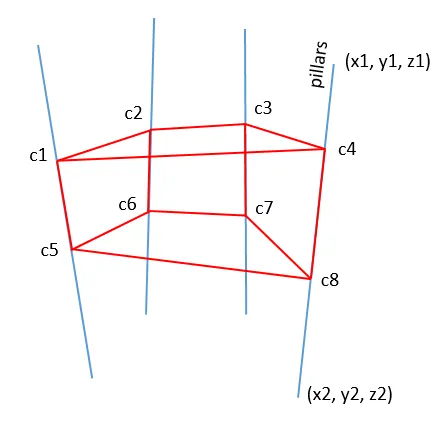

Corner point grid is specified, for example, in the Norne reservoir model that should be downloaded separately, for example, from the `opm-data` repository https://github.com/OPM/opm-data/tree/master/norne. Once the source files of the reservoir model are obtained, load the model data:

In [6]:
model_norne = Field(path='some/path/NORNE_ATW2013.DATA').load()

INFO:Field:Using default config.
INFO:Field:Start reading NORNE_ATW2013.DATA
INFO:Field:[NORNE_ATW2013.DATA:11] Loading DIMENS
INFO:Field:[NORNE_ATW2013.DATA:19] Loading OIL
...
INFO:Field:Finish reading BC0407_HIST01122006.SCH
INFO:Field:Finish reading NORNE_ATW2013.DATA
INFO:Field:MINPV 500.0 is applied.
                PVTG table is converted into PVDG one.
INFO:Field:===== Field summary =====
INFO:Field:GRID attributes: MAPAXES, DIMENS, COORD, ZCORN, ACTNUM, MINPV
INFO:Field:ROCK attributes: PORO, NTG, PERMX, PERMY, PERMZ, MULTZ, SWATINIT, SWL, SWCR, SGU, SGL, SGCR, SOWCR, SOGCR, SWU, ISWCR, ISGU, ISWL, ISWU, ISGL, ISOGCR, ISOWCR
INFO:Field:STATES attributes: 
INFO:Field:TABLES attributes: PVTO, ROCK, PVTW, DENSITY, SWOF, SGOF, RSVD, PVDG
INFO:Field:WELLS attributes: WCONPROD, WCONINJE, WELSPECS, WELLTRACK, COMPDAT
INFO:Field:FAULTS attributes: FAULTS, MULTFLT
INFO:Field:AQUIFERS attributes: 
INFO:Field:=========================


`DIMENS` contains model grid dimensionality

In [7]:
model_norne.grid.dimens

array([ 46, 112,  22])

Coordinates of grid pillars are contained in COORD atributes. Each pillar is defined by 6 numbers, coordinates of 2 points ($x_1$, $y_1$, $z_1$) and
($x_2$, $y_2$, $z_2$). Totally $(n_x+1)\times(n_y+1)$ pillars are defined.

In [8]:
model_norne.grid.coord.shape

(47, 113, 6)

$z$ coordinates of blocks are contained in ZCORN keyword. Each block is defined by it`s 8 corners.

In [9]:
model_norne.grid.zcorn.shape

(46, 112, 22, 8)

## Basic properties

List of grid attributes

In [10]:
model_norne.grid.attributes

('MAPAXES', 'DIMENS', 'COORD', 'ZCORN', 'ACTNUM', 'MINPV')

Grid dimensions

In [11]:
model_norne.grid.dimens

array([ 46, 112,  22])

Active cells and the number of active cells:

In [12]:
model_norne.grid.actnum.shape, model_norne.grid.actnum.sum()

((46, 112, 22), 44291)

Grid location with respect to map coordinates and unit vectors in x and y grid directions can be obtained as follows:

In [13]:
model_norne.grid.origin, model_norne.grid.ex, model_norne.grid.ey

(array([   0.   ,    0.   , 3037.473]), array([1., 0.]), array([0., 1.]))

Attribute `cell_centroinds` gives (x, y, z) coordinates of cell centres for active cells. The output array has shape (number_of_active_cells, 3):

In [14]:
model_norne.grid.cell_centroids.shape

(44291, 3)

In hte above array, positional index along the first axis is the the raveled positional index of active cell. To get a mapping from raveled positional index of active cell to (i, j, k) use ```id_to_ijk``` method. For example, first active cell (which has raveled positional index 0) corresponds to the cell with indices [5, 10, 0]:

In [15]:
model_norne.grid.id_to_ijk(0)

array([ 5, 10,  0], dtype=int64)

Raveled index of active cell is obtained using ```ijk_to_id```:

In [16]:
model_norne.grid.ijk_to_id([5, 10, 0])

[0]

Propetry `cell_volumes` gives volumes of the active cells:

In [17]:
model_norne.grid.cell_volumes.shape

(44291,)

Property ```bounding_box``` returns (xmin, ymin, zmin, xmax, ymax, zmax) coordinates of bounding box:

In [18]:
model_norne.grid.bounding_box

array([4.53114000e+05, 7.31583550e+06, 2.23026001e+03, 4.65658625e+05,
       7.33111950e+06, 3.50841309e+03])

Orthogonal grids can be represented as corner point grids using `as_corner_point` attribute:

In [19]:
print('Attributes of the orthogonal grid: ', model_egg.grid.attributes)
print('Attributes of the corner-point representation: ', model_egg.grid.as_corner_point.attributes)

Attributes of the orthogonal grid:  ('MAPAXES', 'DIMENS', 'ACTNUM', 'DX', 'DY', 'DZ', 'TOPS')
Attributes of the corner-point representation:  ('DIMENS', 'MAPAXES', 'ACTNUM', 'ZCORN', 'COORD')


## VTK grid

Actually, each grid is represented as VTK unstructured grid that can be accessed using the attribute ```vtk_grid```:

In [20]:
model_norne.grid.vtk_grid

<vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x0000026B2CEBB960) at 0x0000026B0493A5C0>

Using the vtk interface https://vtk.org/doc/nightly/html/classvtkUnstructuredGrid.html, one can manpulate with vtk grid:

In [21]:
model_norne.grid.vtk_grid.GetNumberOfPoints(), model_norne.grid.vtk_grid.GetNumberOfCells()

(141857, 44291)

For example, vertices of each active cell can be obtained as follows:

In [22]:
from vtkmodules.util.numpy_support import vtk_to_numpy

vtk_to_numpy(model_norne.grid.vtk_grid.GetCell(0).GetPoints().GetData())

array([[4.55586438e+05, 7.32115450e+06, 2.58673901e+03],
       [4.55608344e+05, 7.32107300e+06, 2.56884692e+03],
       [4.55660469e+05, 7.32114000e+06, 2.57869995e+03],
       [4.55638062e+05, 7.32122100e+06, 2.59923193e+03],
       [4.55584250e+05, 7.32115650e+06, 2.59356909e+03],
       [4.55606031e+05, 7.32107250e+06, 2.57588696e+03],
       [4.55658531e+05, 7.32114050e+06, 2.58564307e+03],
       [4.55636344e+05, 7.32122300e+06, 2.60572412e+03]])

Note that you can get vertices of inactive cells using ```get_xyz``` method. For example, to get vertices of the cell [0,0,0] use
```python
model.grid.get_xyz([0,0,0])
```
Note that the order of vertices in `vtk` and `get_xyz` is different.  Order in `get_xyz` is
```
   2 -- 3
  /|   /|
0 -- 1  |
|  | |  |
|  6 -- 7
| /  | /
4 -- 5
```
Order in `vtk` is
```
   3 -- 2
  /|   /|
0 -- 1  |
|  | |  |
|  7 -- 6
| /  | /
4 -- 5
```

Next we consider grid transformations.

## Rescaling

Orthogonal grids can be upscaled and downscaled, for corner point grids only upscaling is implemented. Parameter `factors` specifices scaling factor along each axis. Additional parameter `actnum_upscale` specifies how to transfer active cell into the new grid:

In [23]:
up_grid = model_norne.grid.upscale(factors=(4, 4, 5), actnum_upscale='vote')
print('Original:', model_norne.grid.dimens, 'Upscaled:', up_grid.dimens)

Original: [ 46 112  22] Upscaled: [11 28  4]


Dowscaling is implemented for orthogonal grids only.

In [24]:
down_grid = model_egg.grid.downscale(factors=(2, 1, 3))
print('Original:', model_egg.grid.dimens, 'Upscaled:', down_grid.dimens)

Original: [60 60  7] Upscaled: [120  60  21]


Done!